McSAS3, a reimplemented Monte-Carlo analyser for Scattering patterns.
==

Introduction
--
The original McSAS (1,2) has been used by many researchers to analyse scattering patterns. This approach can determine form-free parameter distributions from scattering patterns (e.g. size distributions) assuming only a scatterer shape. 

However, that implementation had fundamental limitations. To resolve these limitations, McSAS3 was developed, a refactoring of the entire codebase to more modern standards. This refactoring has several advantages, chief among them:
  - Using the SasModels library from the SasView package, with many tried and tested GPU-accelerated models and model extensions in it. Combined models should also be possible (untested).
  - Alternatively, models can be simulated from free-form objects described in STL form via the SPONGE scattering pattern simulator (limited information on the SPONGE in (3)). These can then be used as base objects in McSAS3.
  - Multi-core optimization is enabled, each repetition can occupy its own thread
  - re-instantiating and rehistogramming an existing optimization is now possible
  - All steps in the fitting and histogramming process are extensively documented in a clear, hierarchical NeXus-like structure (HDF5-compatible)
  - Completely separated from UI enables scripted analyses of large datasets on servers or clusters
  - Modifiable random number pickers for speed improvements, usually linear or inverse logarithmic probability
  
Usage:
--
This notebook shows an example usage of McSAS3, leveraging some of the possibilities of the code. However, it does not work automatically, there are bits that need to be adapted. 

Firstly, in the import section, change the two paths to wherever you have the SasView and McSAS3 codebase installed, respectively. # NOTE: this could be solved with git imports maybe?

Secondly, there is the file loading section. Here, you must make sure that your 1D data is loaded correctly, complete with uncertainty estimates. A plot is provided to help you. 
The McData class supports the following formats:
  - 3-column ascii files, which require you to set the csv loader arguments correctly. This data must be in units of Q: 1/nm, I: 1/(m sr), ISigma: 1/(m sr). 
  - NXcanSAS files are supported # NOTE: double-check. 
  - pdh files are supported (Anton Paar's 1D format)
  - data stored in previous McSAS3 runs are supported
  - 2D data must be provided in NXcanSAS format, a compatible HDF5 file (e.g. from DAWN) or from a previous McSAS3 run. 

Thirdly, both the scattering model, and the optimizer are configured and the optimization is run

Fourthly, the histogrammer is set up and provided with a few ranges for a few parameters. Feel free to modify as needed. 

Fifthly, the reporting functions are demonstrated that create a report very similar to what was produced by the original McSAS code. 

Lastly, it is shown how the histogrammer can be adjusted and re-run without rerunning the optimizer. 

Not implemented:
--
McSAS3 is missing some features that were in the original McSAS. These were left out for one of two reasons, either 1) the authors feel their utility is limited, or 2) we have not yet discovered the best way to implement these. These include:
  - Slit- and point smearing. These will be implemented in the future once we figure out how to leverage the implementations in SasModels
  - Weighting compensation: this is left out on purpose, as we found in practice most if not all patterns can be fit using inverse volume-weighting on the intensity. Omission simplifies the code, making it easier to maintain
  - weighting of resulting histograms other than volume-weighting. As the data in scattering most closely represents volume-weighted size information, this representation is the most accurate. Other weightings are sometimes possible (on a case-by-case basis, depending on the width and shape of the distribution) but this transformation must be done by the user. 
  - Observability limits. This was found to be the most confusing indicator in the original McSAS, and is represented with similar approximate accuracy by the error bar uncertainty. This may be reimplemented at a later stage an an optional plottable.
  
  1. https://doi.org/10.1107/S0021889813001295
  2. https://doi.org/10.1107/S1600576715007347
  3. https://doi.org/10.1038/s41467-020-15422-6


Imports
--

This section imports the necessary packages (and maybe a few extra for good measure), and shows what models are available in the SasModels library. One way to make sure all required Python modules are installed, is by running:

    pip install -r ../requirements.txt

In [1]:
# import all the necessary bits and bobs

import h5py, sys, os
import numpy as np
import pandas
# import scipy
# import multiprocessing
from pathlib import Path

# load required modules
homedir = os.path.expanduser("~")
# disable OpenCL for multiprocessing on CPU
os.environ["SAS_OPENCL"] = "none"

# CHANGE to location where the SasView/sasmodels are installed
#sasviewPath = os.path.join(homedir, "Code", "sasmodels")  # <-- change! 
#if sasviewPath not in sys.path:
#    sys.path.append(sasviewPath)
# import from this path
import sasmodels
import sasmodels.core
import sasmodels.direct_model

# CHANGE this one to whereever you have mcsas3 installed:
# (if its not in the parent directory)
mcsasPath = os.path.join("..")
if mcsasPath not in sys.path:
    sys.path.append(mcsasPath)

# import from this path:
from mcsas3.mc_hat import McHat
from mcsas3.mc_data_1d import McData1D
from mcsas3.mc_analysis import McAnalysis
# optimizeScalingAndBackground: takes care of the calculation of the reduced chi-squared value, after a least-squares optimization for the scaling and background factors.
# McModel: extends the SasModel with information on the parameter set and methods for calculating a total scattering intensity from multiple contributions. It also tracks parameter bounds, random generators and picks.
# McOpt: contains mostly settings related to the optimization process. Also keeps track of the contribution to optimize.
# McCore: Contains the methods required to do the optimization. 

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

---

1D Data fit using McSAS3
== 

The 1D tests loads the standard McSAS Quickstartdemo dataset, which is a simulated dataset of a trimodal distribution of spheres. These modes are centered around 10, 50 and 100 nm. 

In [2]:
# set a filename for documenting the fit:
resPath = Path("..", "testdata", "quickstartdemo1_fitResult.h5")
# delete if it exists:
if resPath.is_file(): resPath.unlink()

Data loading:
--
We have a class for this, which loads the data, clips and rebins the data as requested. We always recommend rebinning the data to about 100 datapoints per decade in Q as a rule of thumb, to speed up the fitting itself. 

data fed to McSAS3 is binnedData


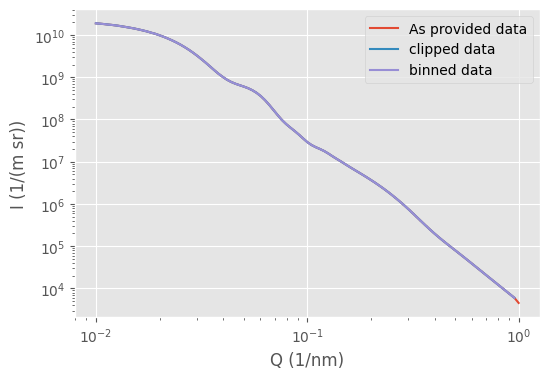

In [3]:
# measurement data:
mds = McData1D(
    filename=Path("..", "testdata", "quickstartdemo1.csv"),
    nbins=0, # no rebinning in this example
    dataRange = [0.01, 1], # this clips the data to the specified range

    # arguments for pandas.read_csv:
    csvargs = {"sep" : ';', # field delimiter, for flexible whitespace, use: "\s+|\t+|\s+\t+|\t+\s+" (https://stackoverflow.com/questions/15026698/how-to-make-separator-in-pandas-read-csv-more-flexible-wrt-whitespace-for-irreg#15026839)
               "skipinitialspace" : True, # ignore initial blank spaces
               "skip_blank_lines" : True, # ignore lines with nothing in them
               "skiprows" : 0, # skip this many rows before reading data (useful for PDH, which I think has five (?) header rows?)
               "engine": "python", # most flexible
               "header" : None, # let's not read any column names since they're unlikely to match with our expected column names:
               "names": ["Q", "I", "ISigma"], # our expected column names
               "index_col" : False}, # no index column before every row (who does this anyway?)
)

# store the data and all derivatives in the output file:
mds.store(resPath)

# plot the loaded data
fhs, ahs = plt.subplots(nrows = 1, ncols = 1, figsize = [6, 4], dpi=100)
mds.rawData.plot('Q', 'I', yerr= 'ISigma', ax = ahs, label = 'As provided data')
mds.clippedData.plot('Q', 'I', yerr= 'ISigma', ax = ahs, label = 'clipped data')
mds.binnedData.plot('Q', 'I', yerr= 'ISigma', ax = ahs, label = 'binned data')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q (1/nm)')
plt.ylabel('I (1/(m sr))')
# plt.xlim([0.1, 3])
print(f'data fed to McSAS3 is {mds.measDataLink}')
md = mds.measData.copy() # here we copy the data we want for fitting.

Models
--
Once we are happy with our data, we can choose a fitting model. We have the following models available:

In [4]:
# show me all the available models, 1D and 1D+2D

print("\n \n 1D-only SasModel Models:\n")
print(" -- \n")

for model in sasmodels.core.list_models():
    modelInfo = sasmodels.core.load_model_info(model)
    if not modelInfo.parameters.has_2d:
        print(f" \t * {modelInfo.id}")

print("\n \n 2D- and 1D- SasModel Models:\n")
print(" -- \n")
for model in sasmodels.core.list_models():
    modelInfo = sasmodels.core.load_model_info(model)
    if modelInfo.parameters.has_2d:
        print(f" \t * {modelInfo.id}")


 
 1D-only SasModel Models:

 -- 

 	 * adsorbed_layer
 	 * be_polyelectrolyte
 	 * binary_hard_sphere
 	 * broad_peak
 	 * core_multi_shell
 	 * core_shell_sphere
 	 * correlation_length
 	 * dab
 	 * flexible_cylinder
 	 * flexible_cylinder_elliptical
 	 * fractal
 	 * fractal_core_shell
 	 * fuzzy_sphere
 	 * gauss_lorentz_gel
 	 * gaussian_peak
 	 * gel_fit
 	 * guinier
 	 * guinier_porod
 	 * hardsphere
 	 * hayter_msa
 	 * hollow_rectangular_prism_thin_walls
 	 * lamellar
 	 * lamellar_hg
 	 * lamellar_hg_stack_caille
 	 * lamellar_stack_caille
 	 * lamellar_stack_paracrystal
 	 * line
 	 * linear_pearls
 	 * lorentz
 	 * mass_fractal
 	 * mass_surface_fractal
 	 * micromagnetic_FF_3D
 	 * mono_gauss_coil
 	 * multilayer_vesicle
 	 * onion
 	 * peak_lorentz
 	 * pearl_necklace
 	 * poly_gauss_coil
 	 * polymer_excl_volume
 	 * polymer_micelle
 	 * porod
 	 * power_law
 	 * pringle
 	 * raspberry
 	 * rpa
 	 * sphere
 	 * spherical_sld
 	 * spinodal
 	 * squarewell
 	 * star_poly

For our example, we choose the sphere model, but other models work in a similar manner. These models often contain many parameters special for magnetic (neutron) scattering, which can be safely ignored for X-ray scattering purposes. 

We can get some information on the default parameters and model information using the following segment: 

In [5]:
model = sasmodels.core.load_model_info('sphere')
print("\n Current model parameters, their defaults and their units: \n") # not sure how to get parameter units yet
_=[print(f"{param.name :>20}: {model.parameters.defaults[param.name]:>8}, {param.units :>12}") for param in model.parameters.call_parameters]
# get some more information:
print('\n == \n Current model offline documentation:')
print(model.docs)


 Current model parameters, their defaults and their units: 

               scale:        1,             
          background:    0.001,         1/cm
                 sld:        1,   1e-6/Ang^2
         sld_solvent:        6,   1e-6/Ang^2
              radius:       50,          Ang
           up_frac_i:      0.0,             
           up_frac_f:      0.0,             
            up_theta:     90.0,      degrees
              up_phi:      0.0,      degrees
              sld_M0:      0.0,   1e-6/Ang^2
          sld_mtheta:      0.0,      degrees
            sld_mphi:      0.0,      degrees
      sld_solvent_M0:      0.0,   1e-6/Ang^2
  sld_solvent_mtheta:      0.0,      degrees
    sld_solvent_mphi:      0.0,      degrees

 == 
 Current model offline documentation:

For information about polarised and magnetic scattering, see
the :ref:`magnetism` documentation.

Definition
----------

The 1D scattering intensity is calculated in the following way (Guinier, 1955)

.. math::

    I(

Configuring the optimizer with the model name and its parameters.
--
Here we use a convenience function McHat (sits on top of everything), that instantiates the optimizer and the model, and stores the configuration in the results structure. In principle, you can then take this preconfigured file with the data and settings, and submit it to some server for running, as it has all the necessary information for the optimization (not for the histogramming yet). Useful for users with limited computing resources. # NOTE: An idea for exploiting free cloud computing resources? :). 


In [6]:
# configures the model the Monte Carlo optimizer:

mh = McHat(
            modelName="sphere", # the model name chosen from the list above
            nContrib=300, # number of contributions, 300 normally suffice
            modelDType="default", # choose "fast" for single-precision calculations at your own risk
            fitParameterLimits={"radius": (3.14, 314)}, # this is the parameter we want to MC optimize within these bounds
            staticParameters={ # these are the parameters we don't want to change:
                "background": 0, # is optimized separately, always set to zero
                "scale": 1, # ibid.
                "sld": 77.93, # SLD of silver 
                "sld_solvent": 9.45,# SLD of water
                },
            maxIter=100000, # don't try more than this many iterations
            convCrit=1, # convergence criterion, should be 1 if reasonable uncertainty estimates are provided, to prevent over- or under-fitting
            nRep=10, # number of independent repetitions of the optimization procedure. 10 for fast, 50-100 for publications
            nCores=0, # number of threads to spread this over. Set to 0 for automatic detection of maximum number of threads
            seed=None, # random number generator seed. Set to a specific value for reproducible random numbers
        )
mh.store(resPath)

In [7]:
question = "This will run the optimization which can take a few minutes. Are you sure? Y/N"
if 'PYTEST_CURRENT_TEST' in os.environ:
    ans = 'Y'
    display(question+' '+ans)
else:
    ans = input(question)
if ans.lower() == 'y':
    mh.run(md, resPath)

This will run the optimization which can take a few minutes. Are you sure? Y/N Y


McSAS analysis with 10 repetitions took 13.5s with 10 threads.
Optimization of repetition 0 started:
chiSqr: 4687.677773627522, N accepted: 0 / 0
chiSqr: 4687.677773627522, N accepted: 0 / 1
chiSqr: 127.19374283454604, N accepted: 357 / 1001
chiSqr: 14.379660290820748, N accepted: 528 / 2001
chiSqr: 3.6506228242696466, N accepted: 600 / 3001
chiSqr: 1.634707334933592, N accepted: 640 / 4001
Final chiSqr: 0.8762147088107574, N accepted: 654

Optimization of repetition 1 started:
chiSqr: 23580.73454347122, N accepted: 0 / 0
chiSqr: 23312.460561438576, N accepted: 1 / 1
chiSqr: 137.01541620002726, N accepted: 383 / 1001
chiSqr: 14.61512809240039, N accepted: 543 / 2001
chiSqr: 2.491338225694021, N accepted: 631 / 3001
chiSqr: 1.1045035012102553, N accepted: 662 / 4001
Final chiSqr: 0.9697502940645237, N accepted: 671

Optimization of repetition 2 started:
chiSqr: 11962.531116114129, N accepted: 0 / 0
chiSqr: 11930.192157263367, N accepted: 1 / 1
chiSqr: 135.74152114861008, N accepted: 365

Histogramming the result
--
Now that the optimization has run, we can histogram the result as we like. For this, we need to select 1) which parameter we want to histogram (which in this case can only be 'radius'), and 2) how we would like to histogram this. Note that the report is not automatically generated. 

In [8]:
# histogram the result, This doesn't take so long and can be repeated as required.
histRanges = pandas.DataFrame(
    [
        dict(
            parameter="radius",  # we only varied one parameter, so not much choice here
            nBin=50,             # number of bins
            binScale="log",      # logarithmically spaced along x
            binWeighting="vol",  # volume weighting (only option as of yet)
            autoRange=True,      # automatically sets min/max to histogram all
        ),
        dict(
            parameter="radius",  # same
            nBin=20,             # but only 20 bins
            binScale="linear",   # linear x-axis spacing
            presetRangeMin=3.14, # minimum
            presetRangeMax=25,   # maximum (only first mode)
            binWeighting="vol",  # volume-weighted
            autoRange=False,     # no auto-ranging (only a subset within the specified parameter range)
        ),
        dict(
            parameter="radius",
            nBin=20,
            binScale="linear",
            presetRangeMin=25,
            presetRangeMax=75,
            binWeighting="vol",
            autoRange=False,
        ),

        dict(
            parameter="radius",
            nBin=20,
            binScale="linear",
            presetRangeMin=75,
            presetRangeMax=150,
            binWeighting="vol",
            autoRange=False,
        ),
    ]
)

mcres = McAnalysis(resPath, md, histRanges, store=True)

Getting List of repetitions...
10 repetitions found in McSAS file ../testdata/quickstartdemo1_fitResult.h5
Histogramming every repetition and extracting elements to average...
Averaging population modes...
Averaging histograms...
Averaging optimization parameters...
Averaging model intensity...
Storing averages...


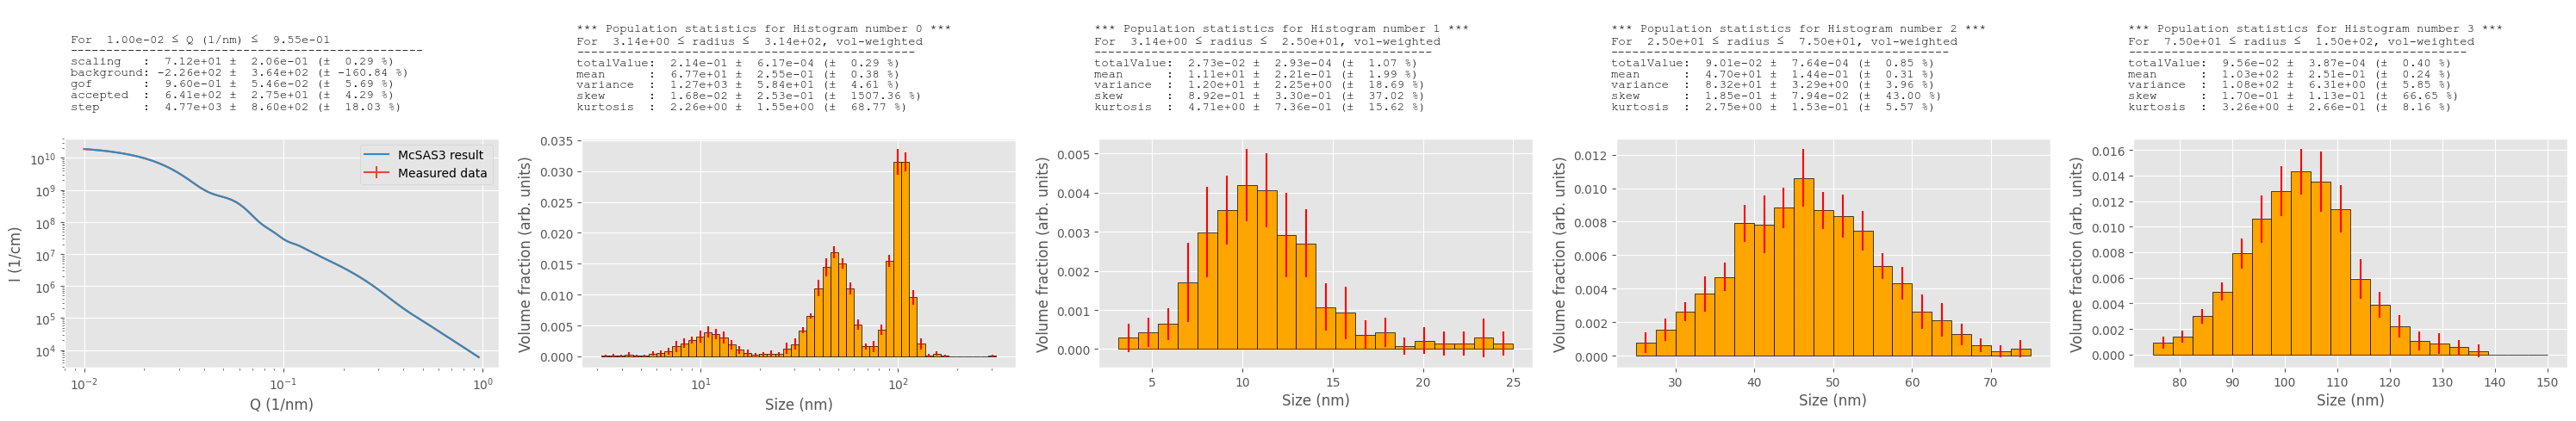

In [9]:
## plot the histogram result in a report similar to the original McSAS
# Set up the plotting frame
fhs, ahs = plt.subplots(
    nrows = 2, 
    ncols = 1+len(histRanges), 
    figsize = [6 * (1+len(histRanges)), 5],
    dpi = 100,
    gridspec_kw={
        'width_ratios':list(np.ones(len(histRanges) + 1)), 
        'height_ratios':[1,2]
        }
    )
csfont = {'fontname':'monospace'}


# plot a histogram for every histRange:
for histNum, histRange in histRanges.iterrows():
    histDataFrame = mcres._averagedHistograms[histNum]
    plt.sca(ahs[1, 1 + histNum])
    plt.bar(
        histDataFrame['xMean'], 
        histDataFrame['yMean'], 
        align = 'center', 
        width = histDataFrame['xWidth'],
        yerr = histDataFrame['yStd'],
        facecolor = 'orange',
        edgecolor = 'black',
        ecolor = 'red',
        )
    plt.xscale(histRange.binScale)
    plt.xlabel('Size (nm)')
    plt.ylabel('Volume fraction (arb. units)')

    # get report, some string replacements to prevent errors of "missing Glyph (9), which is the tab"
    histReport = mcres.debugReport(histNum)#.split('\n', 1)[1]
    plt.sca(ahs[0, 1 + histNum]) # top right
    ahs[0,1 + histNum].set_aspect(1)
    ahs[0,1 + histNum].axis('off')
    ahs[0,1 + histNum].text(.2, 0, histReport, **csfont, 
        rotation=0,
        horizontalalignment='center',
        verticalalignment='bottom',
        multialignment='left',
        transform=ahs[0,1 + histNum].transAxes,
        bbox=dict(facecolor='white', alpha=0)
    )


# plot data and fit:
plt.sca(ahs[1, 0])
mds.binnedData.plot('Q', 'I', yerr= 'ISigma', ax = ahs[1,0], label = 'Measured data', zorder = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Q (1/nm)')
plt.ylabel('I (1/cm)')
# plt.xlim(1e-1, 2)
plt.plot(mcres._measData['Q'][0], mcres.modelIAvg.modelIMean.values, zorder = 2, label = 'McSAS3 result')
plt.legend()

# plot fitting statistics:
runReport = mcres.debugRunReport().split('\n', 1)[1]
plt.sca(ahs[0, 0])
ahs[0,0].set_aspect(1)
ahs[0,0].axis('off')
ahs[0,0].text(.2, 0, runReport, **csfont, 
    rotation=0,
    horizontalalignment='center',
    verticalalignment='bottom',
    multialignment='left',
    transform=ahs[0,0].transAxes,
    bbox=dict(facecolor='white', alpha=0)
)
plt.tight_layout()


# save into PDF:
plt.savefig(Path(resPath.parent, resPath.stem+'.pdf'))